In [1]:
import numpy as np
from scipy.optimize import curve_fit
from src import *
import matplotlib.pyplot as plt


# OCC

In [2]:
 # from the meta analysis: https://inldigitallibrary.inl.gov/sites/sti/sti/Sort_107010.pdf\n# Table 29
 # # Large reactors
 
 OCC_large_conservative = 7750 # USD/kW
 OCC_large_moderate = 5750
 cons_duration_large_conservative = 125 #(months)
 cons_duration_large_moderate = 82 #(months)
 power_large_ref = 1000 # MWe
 
 # SMR
 OCC_SMR_conservative = 10000 # USD/kW
 OCC_SMR_moderate =7750 
 cons_duration_SMR_conservative = 71 #(months)
 cons_duration_SMR_moderate = 55 #(months)
 power_SMR_ref = 200 # MWe # the average power of the SMR in the sheet is 200 
 
 #Microreactors\n# from the lit review : https://www.osti.gov/biblio/1986466: Table 17 (scaled data) only OCC. The data that had the financing cost were excluded
 # # all of them are multuplied by 1.175625 (inflation multuplier from 2019 to 2023) using :https://fred.stlouisfed.org/series/GDPDEF#0\n
 MR_cost_1  = 10000 * 1.175625 
 MR_cost_2 = + 15000 *1.175625
 MR_cost_3 =  20000 * 1.175625
 MR_cost_4 = 3996 * 1.175625  
 MR_cost_5 = 8276  * 1.175625 
 MR_cost_6 = 14973 * 1.175625
 MR_cost_average =np.mean ([MR_cost_1,MR_cost_2, MR_cost_3, MR_cost_4,MR_cost_5, MR_cost_6 ])
 MR_cost_std = np.std ([MR_cost_1,MR_cost_2, MR_cost_3, MR_cost_4,MR_cost_5, MR_cost_6 ])
 
power_micro_ref = 5 # MW
cons_duration_micro_conservative = 36 #(months) # I assumed this!
 
OCC_micro_conservative = MR_cost_average + MR_cost_std # USD/kW
OCC_micro_moderate = MR_cost_average
 
 # now lets do curve fitting\n
 def func(x, a, b):  
    return a*(x**b)

xdata = [ power_large_ref,  power_SMR_ref,power_micro_ref ]
ydata = [ OCC_large_conservative,  OCC_SMR_conservative, OCC_micro_conservative  ]
popt, p_cov = curve_fit(func, xdata , ydata)

def occ_for_power(P):
    return popt[0] *(P**popt[1])

def construction_duration_power(P):
    if P > 500:
        duration =  cons_duration_large_conservative
    if P <= 500 and P > 50:
         duration =  cons_duration_SMR_conservative
    elif P<= 50:     
        duration =  cons_duration_micro_conservative
    return duration

# TCI

In [19]:
def capital_investment(P, interest_rate):
    construction_duration = construction_duration_power(P)
    tot_overnight_cost = occ_for_power(P)
    
    # Interest rate from this equation (from Levi)
    B =(1+ np.exp((np.log(1+ interest_rate)) * construction_duration/12))
    C  =((np.log(1+ interest_rate)*(construction_duration/12)/3.14)**2+1)
    Interest_expenses = tot_overnight_cost*((0.5*B/C)-1)
    return (Interest_expenses + tot_overnight_cost) # this is TCI in $/kw

def tot_TCI_multiple_reactors (P, interest_rate, num_reactors): # multiple reactors of the same power

    # the capital investment of one reactor ($/kw)
    levlized_TCI = capital_investment(P, interest_rate)
    
    if P >500:
        learning_rate = 0.08
    elif P<=500 :
        learning_rate = 0.095 
    
    # the capital investment of one reactor ($/kw) after the learning rate effect
    final_TCI = calculate_final_cost_due_to_learning_rate(levlized_TCI, learning_rate, num_reactors ) # This is still cost per kw
    final_TCI_one_reactor_levelized = final_TCI *P*1000
    final_TCI_all_reactors = final_TCI_one_reactor_levelized *num_reactors
    return final_TCI_all_reactors # (dollars)

In [23]:
# number of reactors to achieve the target demand 
refueling_period = 30 /7) # days
levelization_period = 30*365

fuel_lifetime = 2*12*30


demand_0 = 1000 # MWe
power_list = [1000, 500, 300] #, 100, 50, 10, 5, 1]
capacity_factor_criteria_list = [0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.999, 0.9999, 0.99999, 1]
num_reactors_save_tot = []
TCI_all_reactors_save_tot = []

for power in power_list :
    num_reactors_save = []
    TCI_all_reactors_save = []
    num_reactors_current = 0 # initialization
    for capacity_factor_criteria in capacity_factor_criteria_list :
    
        num_reactors_0 =  max( int( np.ceil( demand_0 /power)), num_reactors_current)
        for  num_reactors in np.linspace( num_reactors_0 , 2*num_reactors_0, 1+num_reactors_0):
            
                
            times_array_excludingRampUp = (capacity_factor_weeks_approach(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[0]
            # capacity_factor_min =        min ((capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[1])
            overall_capacity_factor   =   (capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[2]
            # print( power, num_reactors, capacity_factor_criteria, overall_capacity_factor  )
            
            if  overall_capacity_factor>=  capacity_factor_criteria:
                num_reactors_save.append(num_reactors)
                TCI_all_reactors = tot_TCI_multiple_reactors (power, 0.075, int(num_reactors)) # assume 7.5 % interest rate # $ /kw
                TCI_all_reactors_save.append(TCI_all_reactors)
                print(power, num_reactors, TCI_all_reactors )
                num_reactors_current = int(num_reactors)
                
                break
    
            
    num_reactors_save_tot.append(num_reactors_save)    
    TCI_all_reactors_save_tot.append( TCI_all_reactors_save)  

1000 1.0 11167776401.247356
1000 1.0 11167776401.247356
1000 1.0 11167776401.247356
1000 1.0 11167776401.247356
1000 2.0 21442130690.394924
1000 2.0 21442130690.394924
1000 2.0 21442130690.394924
1000 2.0 21442130690.394924
1000 2.0 21442130690.394924
1000 2.0 21442130690.394924
500 2.0 10191866270.878275
500 2.0 10191866270.878275
500 2.0 10191866270.878275
500 2.0 10191866270.878275
500 3.0 14759048711.289728
500 3.0 14759048711.289728
500 3.0 14759048711.289728
500 3.0 14759048711.289728
500 3.0 14759048711.289728
500 3.0 14759048711.289728
300 4.0 12629823477.655928
300 4.0 12629823477.655928
300 4.0 12629823477.655928
300 4.0 12629823477.655928
300 4.0 12629823477.655928
300 4.0 12629823477.655928
300 4.0 12629823477.655928
300 4.0 12629823477.655928
300 4.0 12629823477.655928
300 4.0 12629823477.655928


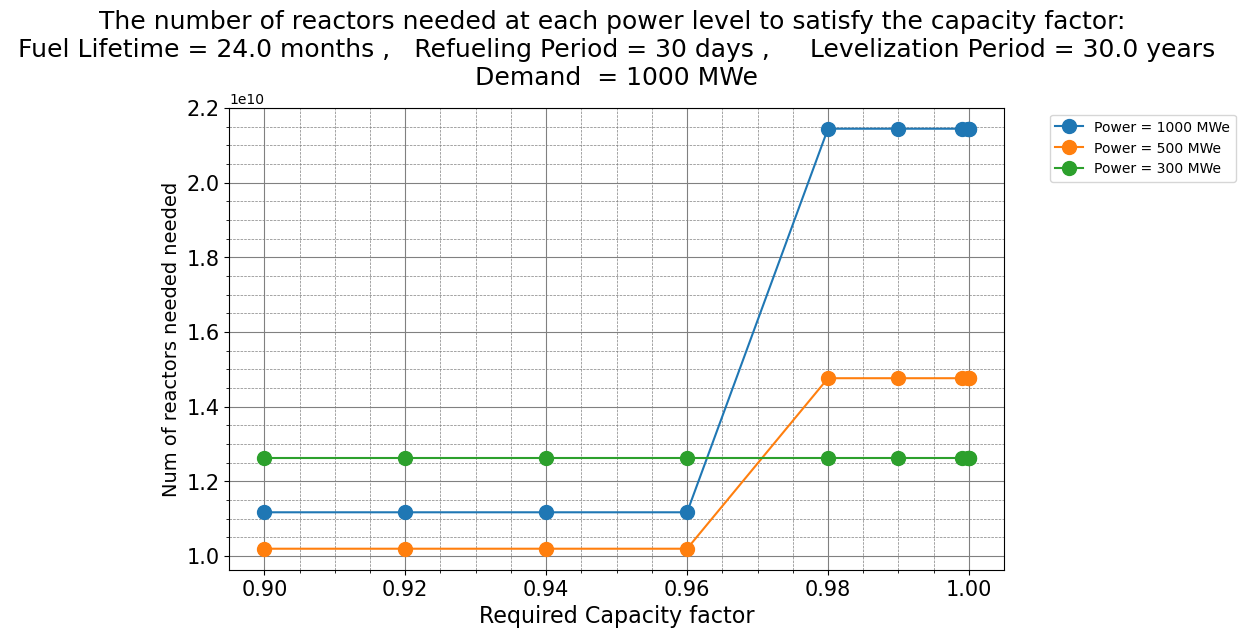

In [24]:
fig = plt.figure(figsize=(10, 6))



for i in range(len(num_reactors_save_tot) ):
    plt.plot(capacity_factor_criteria_list, TCI_all_reactors_save_tot[i], '-o' , markersize = 10, label =f'Power = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# plt.ylim(0, 22)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)

plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
     Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()

NameError: name 'plt' is not defined

# Annualized Cost

In [ ]:
# One of the shortcomings here is that the O&M cost is independent of the fuel lifetime
#Large reactor O&M Costs 
OM_large_hi = 39.8 # Total O&M ($/MWh)
OM_large_medium = 34.6 # Total O&M ($/MWh)

# SMR
OM_SMR_hi = 41.4  # Total O&M ($/MWh)     
OM_SMR_medium = 30.2 # Total O&M ($/MWh)

#Microreactors
# https://inldigitallibrary.inl.gov/sites/sti/sti/Sort_66425.pdf: TABLE 18
 # # multuplied by 1.175625 (inflation multuplier from 2019 to 2023) using :https://fred.stlouisfed.org/series/GDPDEF#0\n

OM_Micro_Avg = 1.175625*np.mean([69, 103, 137, 125, 136, 59]) # 2019$/MWh
OM_Micro_std = 1.175625*np.std([69, 103, 137, 125, 136, 59]) # 2019$/MWh
OM_Mirco_medium = OM_Micro_Avg # $/MWh
OM_Mirco_hi = OM_Micro_Avg+OM_Micro_std # $/MWh

# Microreactor

36.5542924081021